In [34]:
import sys
import os
import re
import csv
import pandas as pd
from versuchung.tex import DatarefDict


def find_keys(prefix, fn):
    with open(fn) as fd:
        text = fd.read()
    for match in re.findall(r"\\drefset{([^}]*)}{([^}]*)}", text):
        yield (prefix+match[0], match[1])

    for match in re.finditer(r"\\drefinput(?:\[(?P<key_prefix>[^\])]*)\])?{(?P<file>[^}]*)}", text):
        key_prefix, fn2 = match.groups()
        key_prefix = key_prefix or ""
        fn2 = os.path.join(os.path.dirname(fn), fn2)
        for ext in ("", ".tex", ".sty"):
            if os.path.exists(fn2 + ext):
                for x in find_keys(prefix + key_prefix, fn2 + ext):
                    yield x
                break

dref = dict(find_keys("", "browserbench.tex"))

benchs = ['speedometer', 'jetstream', 'motionmark']

browserbench = {}
for benchmark in benchs:
    browserbench[benchmark] = {}
    for approach in ['baseline', 'svc-libkpac', 'kpacd-libkpac']:
        browserbench[benchmark][approach] = float(dref[f'/{benchmark}/{approach}{"/avg" if benchmark == "speedometer" else ""}'])

display(browserbench)

{'speedometer': {'baseline': 27.0, 'svc-libkpac': 2.54, 'kpacd-libkpac': 6.1},
 'jetstream': {'baseline': 36.937,
  'svc-libkpac': 5.182,
  'kpacd-libkpac': 10.444},
 'motionmark': {'baseline': 1.21, 'svc-libkpac': 1.04, 'kpacd-libkpac': 1.07}}

,speedometer,jetstream,motionmark
baseline,27.00,36.937,1.21
svc,2.54,5.182,1.04
kpacd,6.10,10.444,1.07


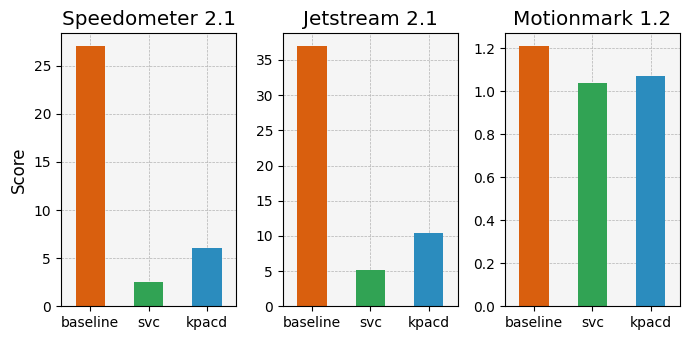

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('bmh')
plt.rcParams["axes.labelcolor"] = "black"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["xtick.color"] = "black"
plt.rcParams["ytick.color"] = "black"
plt.rcParams["xtick.labelcolor"] = "black"
plt.rcParams["ytick.labelcolor"] = "black"
plt.rcParams["axes.labelcolor"] = "black"
plt.rcParams['axes.facecolor'] = '#F5F5F5'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = '0.8'


df = pd.DataFrame(browserbench)
df = df.rename({'kpacd-libkpac': 'kpacd', 'svc-libkpac': 'svc'}, axis=0)

fig, axs = plt.subplots(1,len(benchs),figsize=(7,3.5))
colors = ['#D95F0E','#31a354','#2B8CBE']

display(df)

df["speedometer"].plot.bar(rot=0, ax=axs[0], title='Speedometer 2.1', ylabel='Score', color=colors)
axs[0].set_axisbelow(True)
axs[0].grid(True)

df["jetstream"].plot.bar(rot=0, ax=axs[1], title='Jetstream 2.1', color=colors)
axs[1].set_axisbelow(True)

if 'motionmark' in benchs:
    df["motionmark"].plot.bar(rot=0, ax=axs[2], title='Motionmark 1.2', color=colors)
    axs[1].set_axisbelow(True)
    #axs[1].grid(True)

plt.tight_layout()
plt.savefig("../../fig/browserbench.pdf", bbox_inches='tight')

In [26]:
chromium_row = []

acc = {
    'setup': 0,
    'pac/total': 0,
    'pac/patched': 0,
    'aut/total': 0,
    'aut/patched': 0,
}

with open("kpacd-libkpac.csv") as f:
    csvreader = csv.reader(f)

    for i in csvreader:
        if i[0].endswith('chromium-browser'):
            if chromium_row:
                break
            chromium_row = i
        # print(i)
        acc['setup'] += float(i[1])
        acc['pac/total'] += int(i[2])
        acc['pac/patched'] += int(i[3])
        acc['aut/total'] += int(i[4])
        acc['aut/patched'] += int(i[5])

df = pd.DataFrame(acc, index=['all'])
df.loc['chromium-browser'] = chromium_row[1:]
print(df)

dref_file = "libkpac_data.tex"
try:
    os.unlink(dref_file)
except OSError:
    pass

dref_out = DatarefDict(dref_file)
dref_out.pandas(df)
dref_out.flush()

                        setup pac/total pac/patched aut/total aut/patched
all                  0.571135    410007      399055    492766      466228
chromium-browser  0.549885926    410004      399052    492763      466225
